In [1]:
# This file aimed to trined on a LSTM based on different power and threshould and
# see if it works.
from DataPrepocessing import *
from NeuralNets import *
from TrainMethod import *

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from functools import partial


In [2]:
model = SimpleLSTM()

(612, 833)


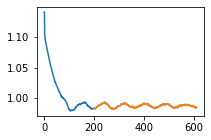

In [3]:
# read the data and only keep the stable state
plt.figure(figsize=(3,2))
raw_data_P1T1 = pd.read_csv("./data/Tracked Files/P1T1.csv")
raw_data_P1T1.fillna(0, inplace= True)
plt.plot(raw_data_P1T1.iloc[:,1])
cut_data_P1T1 = raw_data_P1T1[200:]
plt.plot(cut_data_P1T1.iloc[:,1])
print(raw_data_P1T1.shape)

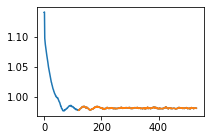

In [4]:
raw_data_P1T09 = pd.read_csv("./data/Tracked Files/P1T0.9.csv")
raw_data_P1T09.fillna(0, inplace= True)
plt.figure(figsize=(3,2))
data = raw_data_P1T09
plt.plot(data.iloc[:,1])
cut_data_P1T09 = data[120:]
plt.plot(cut_data_P1T09.iloc[:,1])

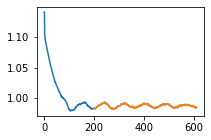

In [5]:
raw_data_P06T1 = pd.read_csv("./data/Tracked Files/P0.6T1.csv")
raw_data_P06T1.fillna(0, inplace= True)
plt.figure(figsize=(3,2))
plt.plot(raw_data_P06T1.iloc[:,1])
cut_data_P06T1 = raw_data_P06T1[200:]
plt.plot(cut_data_P06T1.iloc[:,1])

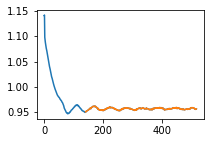

In [6]:
raw_data_P1T11 = pd.read_csv("./data/Tracked Files/P1T1.1.csv")
raw_data_P1T11.fillna(0, inplace= True)
plt.figure(figsize=(3,2))
plt.plot(raw_data_P1T11.iloc[:,1])
cut_data_P1T11 = raw_data_P1T11[140:]
plt.plot(cut_data_P1T11.iloc[:,1])

In [7]:
# now we get all the stable data
print(len(cut_data_P1T1))
print(len(cut_data_P1T11))
print(len(cut_data_P06T1))
print(len(cut_data_P1T09))

# first, cut the data according to the sequence length
sequence_length = 10

time_cut = lambda data : data[: len(data)//sequence_length * sequence_length]

cut_data_P1T11 = time_cut(cut_data_P1T11)
cut_data_P1T1 = time_cut(cut_data_P1T1)
cut_data_P06T1 = time_cut(cut_data_P06T1)
cut_data_P1T09 = time_cut(cut_data_P1T09)

# drop the first timestamp column (OR should we keep it?)

drop_first = lambda data : data.iloc[:, 1:]

cut_data_P1T11 = drop_first(cut_data_P1T11)
cut_data_P1T1 = drop_first(cut_data_P1T1)
cut_data_P06T1 = drop_first(cut_data_P06T1)
cut_data_P1T09 = drop_first(cut_data_P1T09)




print(len(cut_data_P1T1))
print(len(cut_data_P1T11))
print(len(cut_data_P06T1))
print(len(cut_data_P1T09))

412
376
412
413
410
370
410
410


In [8]:
# this function move the keff from the first column to the last
def move_labels(df):
    # move the first column to the last column
    cols = list(df.columns)
    # df = df.iloc[:, 1:] # select all rows and columns except the first one
    df[cols[0]] = df.pop(cols[0]) # remove the first column and append it to the end
    return df


In [9]:
def add_Power_and_Threshold(df, p = 1, t =1):
    df['P'] = p
    df['t'] = t

    return df

In [10]:
cut_data_P1T11 = add_Power_and_Threshold(cut_data_P1T11,1,1.1)
cut_data_P1T1 = add_Power_and_Threshold(cut_data_P1T1,1,1)
cut_data_P06T1 = add_Power_and_Threshold(cut_data_P06T1,0.6,1)
cut_data_P1T09 = add_Power_and_Threshold(cut_data_P1T09,1,0.9)

In [11]:
# question: how to deal with non-fule pebbles?
# question: how to deal with NAN values i.e. different sample number each time stamp

all_data = pd.concat([cut_data_P1T1,cut_data_P1T09 , cut_data_P06T1,cut_data_P1T11 ], ignore_index= True)
all_data.fillna(0, inplace= True)
all_data = move_labels(all_data)
print(all_data.shape)

(1600, 837)


C:\Users\86182\AppData\Local\Temp\ipykernel_38932\3494102704.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[0]] = df.pop(cols[0]) # remove the first column and append it to the end


In [12]:
# do the data preprossing
data = all_data.to_numpy()

data = generate_histogram(data)

data = standarlize(data)


clean_data = data.copy()


In [13]:
data.shape

(1600, 151)

In [14]:
all_data.columns

Index(['keff_relative_uncertainty [/]', 'Cs137_0 [at/b.cm]',
       'Cs137_1 [at/b.cm]', 'Cs137_2 [at/b.cm]', 'Cs137_3 [at/b.cm]',
       'Cs137_4 [at/b.cm]', 'Cs137_5 [at/b.cm]', 'Cs137_6 [at/b.cm]',
       'Cs137_7 [at/b.cm]', 'Cs137_8 [at/b.cm]',
       ...
       'Cs137_826 [at/b.cm]', 'Cs137_827 [at/b.cm]', 'Cs137_828 [at/b.cm]',
       'Cs137_829 [at/b.cm]', 'P', 't', 'Cs137_830 [at/b.cm]',
       'Cs137_831 [at/b.cm]', 'Cs137_832 [at/b.cm]', 'keff [/]'],
      dtype='object', length=837)

In [15]:
training_data = ReactorData(data,10,0,0.75)
testing_data = ReactorData(data,10,0.75,1)

In [16]:
# define neural nets

input_dim = training_data[0][0].shape[1]



# print(output_dim)

# some adjustable hyper-parameters
nets_hyper_parameters = {
'input_dim' : input_dim,
'output_dim' : 1,
'hidden_dim' : 64,
'lstm_nums_layer' : 2,
'dropout' : 0.2 
}


model = SimpleLSTM(**nets_hyper_parameters)

In [17]:
optimizer_parameters = {
    'params':model.parameters(),
    'lr' : 0.01,
    'weight_decay' : 0.01
}

train_parameters = {
    'model' : model,
    'training_data' : training_data,
    'epoch_num': 400,
    'batch_size':16,
    'optimizer' : optim.Adam(**optimizer_parameters),
    'loss_fn' : nn.MSELoss(),
    'print_out_frequency': 20

}


model, _ = train(** train_parameters)

The loss is 0.03597800229482754 in epoch 0
The loss is 0.012835579153236836 in epoch 20
The loss is 0.010024124198596012 in epoch 40
The loss is 0.013696093042818089 in epoch 60
The loss is 0.019810204232185623 in epoch 80
The loss is 0.009165039290598597 in epoch 100
The loss is 0.008832322546349556 in epoch 120
The loss is 0.00970989220649185 in epoch 140
The loss is 0.013189588022946574 in epoch 160
The loss is 0.0077887106043062395 in epoch 180
The loss is 0.01326877504706265 in epoch 200
The loss is 0.011033685122460488 in epoch 220
The loss is 0.02316994788971602 in epoch 240
The loss is 0.010776793745703691 in epoch 260
The loss is 0.012732634984888797 in epoch 280
The loss is 0.009607223992238888 in epoch 300
The loss is 0.008340464994713994 in epoch 320
The loss is 0.012123165631401842 in epoch 340
The loss is 0.0155527166107685 in epoch 360
The loss is 0.006963337737479633 in epoch 380
Training is finished, the final loss is 0.009917525382120795


In [18]:
# visualize the training output
def show(data, model):
    import matplotlib.pyplot as plt


    X = (torch.tensor(data.unshaped_data)).double()
    y = (torch.tensor(data.unshaped_labels)).double()


    plt.figure()
    plt.plot(y, label = "Real")     
    plt.plot(model(X).detach().numpy(), label = "Predict")
    plt.legend()


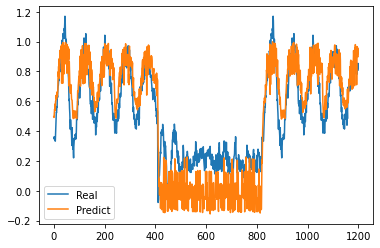

In [19]:
show(training_data, model)

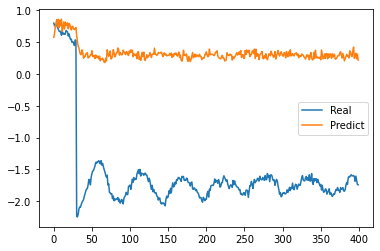

In [20]:
show(testing_data, model)


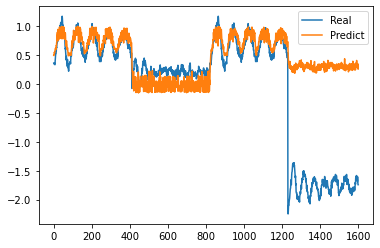

In [21]:
# cut_data_P1T1,cut_data_P1T09 , cut_data_P06T1,cut_data_P1T11

# view all data together
import matplotlib.pyplot as plt


X = (torch.tensor(data[:,:-1])).double()
y = (torch.tensor(data[:,-1:])).double()


plt.figure()
plt.plot(y, label = "Real")     
plt.plot(model(X).detach().numpy(), label = "Predict")
plt.legend()